In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm
import numpy as np
import glob
import subprocess

In [53]:
# combine data form multiple sources (k27act and dhs peaks) 

# laod in the data
k27 = pd.read_table('/home/kal/K27act_models/GM_data/encode_k27act/ENCFF411MHX_peaks.bed', header=None)
k27.columns = 'chr start end name score strand . . . .'.split()
k27['name'] = k27['name'] + '_ENCFF411MHX_k27'

dhs = pd.read_table('/home/kal/K27act_models/GM_data/DHS/ENCFF996CVE_peaks.bed', header=None)
dhs.columns = 'chr start end name score strand . . . .'.split()
dhs['name'] = ['Peak_' + n.split('_')[-1] + '_ENCFF996CVE_dhs' for n in dhs['name']]

#append the two together]
both = k27.append(dhs)
print(len(dhs))
print(len(k27))
print(len(both))

# shrink the regions
both['start'] = (both['start'] + both['end'])//2 - 25
both['end'] = both['start'] + 50

# write out
columns='chr start end name'.split()
both.to_csv('/home/kal/K27act_models/GM_data/all_peaks.bed', columns=columns, header=None, index=False, sep='\t')
both.head()

121517
77413
198930


,chr,start,end,name,score,strand,.,.,.,.
0,chr5,149790997,149791047,Peak_1_ENCFF411MHX_k27,1000,.,89.85265,366.18021,357.29852,6207
1,chr21,44773374,44773424,Peak_2_ENCFF411MHX_k27,931,.,92.61732,341.04700,333.48593,1207
2,chr17,56415612,56415662,Peak_3_ENCFF411MHX_k27,928,.,88.06600,339.85196,332.32996,7583
3,chr1,22107596,22107646,Peak_4_ENCFF411MHX_k27,923,.,92.60819,338.07166,330.55887,5317
4,chr2,191885279,191885329,Peak_5_ENCFF411MHX_k27,889,.,79.87725,325.56088,318.63269,2982


In [58]:
# sort and merge the peaks
# call sort -k1,1 -k2,2n all_peaks.bed > all_peaks_sorted.bed

with open('/home/kal/K27act_models/GM_data/merged_peaks_small.bed', "w") as outfile:
    command = ['bedtools', 'merge', '-c', '4', '-o', 'distinct', '-i', '/home/kal/K27act_models/GM_data/all_peaks_sorted.bed']
    subprocess.call(command, stdout=outfile)
    
# load in the new file          
merged_peaks = pd.read_table('/home/kal/K27act_models/GM_data/merged_peaks_small.bed', header=None)
merged_peaks.columns = columns
merged_peaks['start'] = merged_peaks['start'] - 225
merged_peaks['end'] = merged_peaks['end'] + 225
merged_peaks.to_csv('/home/kal/K27act_models/GM_data/merged_peaks.bed', columns=columns, header=None, index=False, sep='\t')
print(len(merged_peaks))
merged_peaks.head()     

167190


,chr,start,end,name
0,chr1,566561,567061,Peak_1_ENCFF996CVE_dhs
1,chr1,567327,567827,Peak_2_ENCFF996CVE_dhs
2,chr1,569673,570173,Peak_3_ENCFF996CVE_dhs
3,chr1,713665,714165,Peak_19010_ENCFF411MHX_k27
4,chr1,713872,714372,"Peak_4a_ENCFF996CVE_dhs,Peak_4b_ENCFF996CVE_dh..."


In [59]:
bed_path = '/home/kal/K27act_models/GM_data/merged_peaks.bed'
narrow_path = bed_path.split('/')[-1].rsplit('_')[0] + '_narrowpeaks.bed'
counts_path = bed_path.split('/')[-1].rsplit('_')[0] + '_ataccounted_peaks.bed'
annotated_path = bed_path.split('/')[-1].rsplit('_')[0] + '_annotated.bed'
print(annotated_path)

merged_annotated.bed


In [60]:
# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

In [63]:
# annotate a bed file with ATAC
peaks = pd.read_table(bed_path, header=None)
peaks.columns='chr start end name'.split()

for index, row in tqdm(peaks.iterrows(), total=len(peaks)):
    peaks.set_value(index, 'atac_count', sum(atac[row['chr']][row['start']:row['end']]))

#columns = 'chr start end name score strand signalValue pValue qValue peak atac_count'.split()
columns = 'chr start end name atac_count'.split()
peaks.to_csv(counts_path, header=None, index=False, columns=columns, sep='\t')

100%|██████████| 167190/167190 [00:58<00:00, 2855.85it/s]


In [64]:
# make a plot for each _sorted bam file in the given directory
k27act=dict()
dir_path = '/home/kal/K27act_models/GM_data/encode_k27act/'

for bam_path in glob.iglob(dir_path + '**/*_sorted.bam', recursive=True):
    print(bam_path)
    out_path = bam_path.split('_sorted')[0] + '_annotating_' + bed_path.split('/')[-1].rsplit('_')[0] + '_peaks.bed'
    print(out_path)
    #get coverage
    with open(out_path, "w") as outfile:
        command = ['bedtools', 'coverage', '-a', counts_path, '-b', bam_path, '-counts']
        subprocess.call(command, stdout=outfile)
    #load in the files
    name=bam_path.split('_sorted')[0].split('/')[-1]
    print(name)
    k27act[name] = pd.read_table(out_path, header=None)
    k27act[name].columns = 'chr start end name atac k27act'.split()

/home/kal/K27act_models/GM_data/encode_k27act/ENCFF197QHX_sorted.bam
/home/kal/K27act_models/GM_data/encode_k27act/ENCFF197QHX_annotating_merged_peaks.bed
ENCFF197QHX
/home/kal/K27act_models/GM_data/encode_k27act/ENCFF882PRP_sorted.bam
/home/kal/K27act_models/GM_data/encode_k27act/ENCFF882PRP_annotating_merged_peaks.bed
ENCFF882PRP
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASG_sorted.bam
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASG_annotating_merged_peaks.bed
ENCFF000ASG
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASI_sorted.bam
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASI_annotating_merged_peaks.bed
ENCFF000ASI


/home/kal/K27act_models/GM_data/encode_k27act/ENCFF197QHX_stats.txt
/home/kal/K27act_models/GM_data/encode_k27act/ENCFF882PRP_stats.txt
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASI_stats.txt
/home/kal/K27act_models/GM_data/encode_k27act/archived/ENCFF000ASG_stats.txt


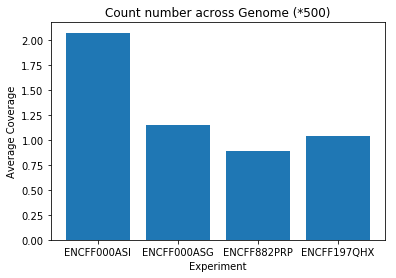

In [66]:
# get average coverage for K27act
averages=dict()
for bam_path in glob.iglob(dir_path + '**/*_stats.txt', recursive=True):
    print(bam_path)
    name=bam_path.split('_stats')[0].split('/')[-1]
    cov = pd.read_table(bam_path, header=None)
    cov.columns = 'chr length mapped unmapped'.split()
    avgk27 = sum(cov['mapped'])/sum(cov['length'])*500
    averages[name] = avgk27
    
norms = [averages[key] for key, table in averages.items()]
plt.bar([1, 2, 3, 4], norms)
plt.xticks([1, 2, 3, 4], averages.keys())
plt.ylabel('Average Coverage')
plt.xlabel('Experiment')
plt.title('Count number across Genome (*500)')
plt.show()

In [ ]:
# get average atac coverage
d = []

for c in peaks.chr.unique():
    print('working on ' + c)
    avg = np.average(atac[c])
    d.append({'chr':c, 'length':len(atac[c]), 'average':avg})
    
atac_chr_avg = pd.DataFrame(d)
atac_chr_avg.to_csv('/home/kal/K27act_models/GM_data/ATAC/atac_average_stats.txt', header=None, index=False, columns='chr length average'.split(), sep='\t')

In [67]:
# if atac already annotated
atac_chr_avg = pd.read_table('/home/kal/K27act_models/GM_data/ATAC/atac_average_stats.txt', header=None)
atac_chr_avg.columns = 'chr length avg'.split()
avg_atac = np.average(atac_chr_avg['avg']) *1000

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2


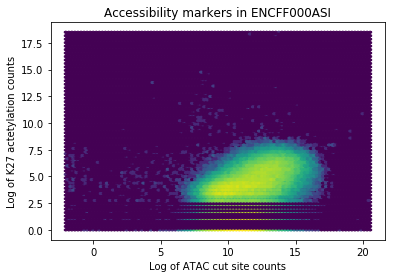

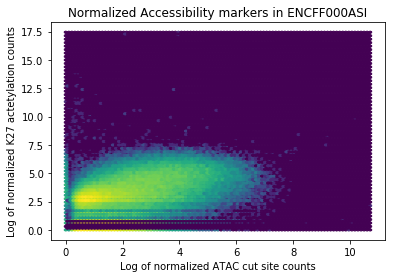

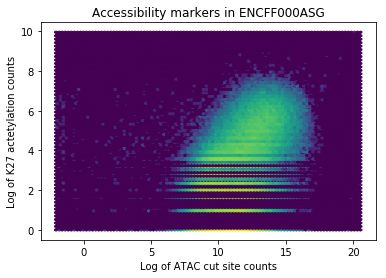

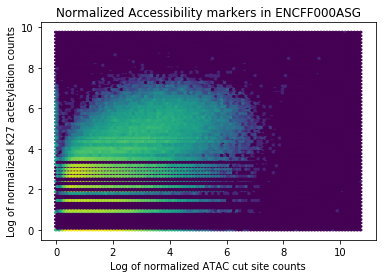

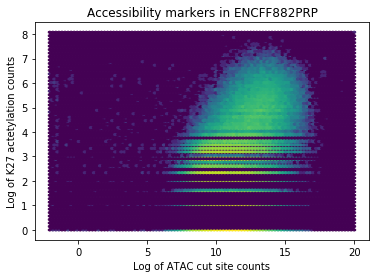

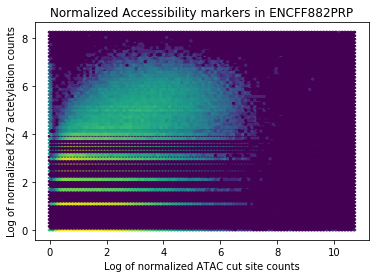

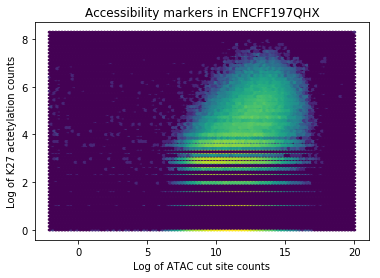

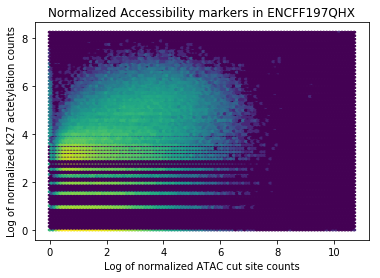

In [68]:
for key, table in k27act.items():
    #plot correlation
    plt.title('Accessibility markers in ' + key)
    plt.ylabel('Log of K27 actetylation counts')
    plt.xlabel('Log of ATAC cut site counts')
    plt.hexbin(np.log2(table['atac']), np.log2(table['k27act']), bins='log')
    plt.show()
    
    table['k27act_norm'] = table['k27act']/averages[key]
    table['atac_norm'] = table['atac']/avg_atac
    
    plt.title('Normalized Accessibility markers in ' + key)
    plt.ylabel('Log of normalized K27 actetylation counts')
    plt.xlabel('Log of normalized ATAC cut site counts')
    plt.hexbin(np.log2(table['atac_norm']+1), np.log2(table['k27act_norm']+1), bins='log')
    plt.show()

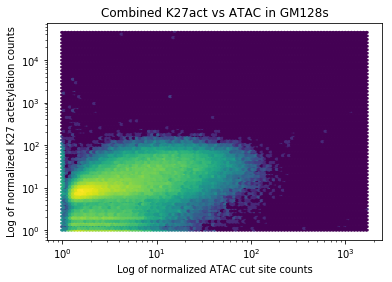

In [75]:
# add a k27act score column
started=False
for key, table in k27act.items():
    if not started:
        normed_score=np.array(table['k27act_norm'])
        started=True
    else:
        normed_score = np.add(normed_score, np.array(table['k27act_norm']))

normed_score = pd.DataFrame(normed_score/len(k27act))
normed_score = normed_score.set_index(peaks.index)
peaks['k27act_norm'] = normed_score
peaks['atac_norm'] = peaks['atac_count']/avg_atac

plt.title('Combined K27act vs ATAC in GM128s')
plt.ylabel('Log of normalized K27 actetylation counts')
plt.xlabel('Log of normalized ATAC cut site counts')
plt.hexbin(peaks['atac_norm']+1, peaks['k27act_norm']+1, bins='log', xscale='log', yscale='log')
plt.show()

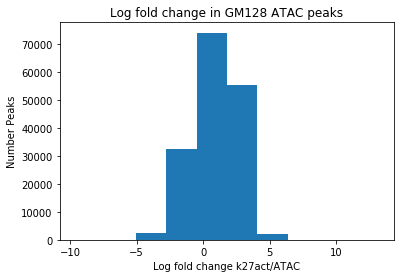

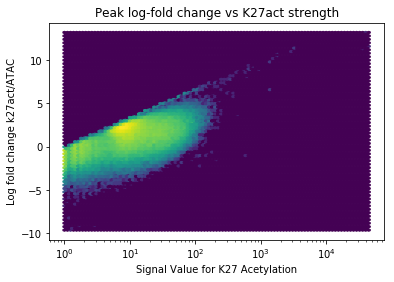

In [70]:
# add a score
peaks['fold_change'] = np.log2((peaks['k27act_norm']+1)/(peaks['atac_norm']+1))
plt.title('Log fold change in GM128 ATAC peaks')
plt.ylabel('Number Peaks')
plt.xlabel('Log fold change k27act/ATAC')
plt.hist(peaks['fold_change'])
plt.show()

plt.title('Peak log-fold change vs K27act strength')
plt.ylabel('Log fold change k27act/ATAC')
plt.xlabel('Signal Value for K27 Acetylation')
plt.hexbin(peaks['k27act_norm'] +1, peaks['fold_change'], bins='log', xscale='log')
plt.show()

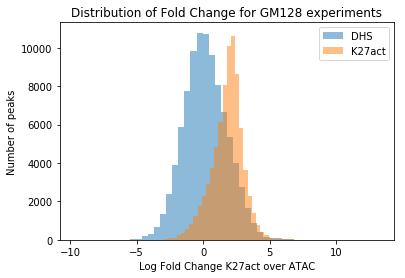

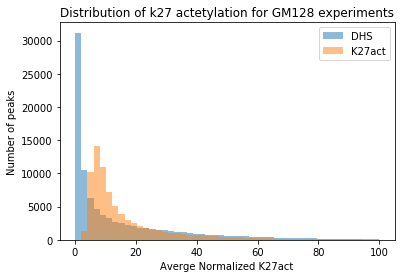

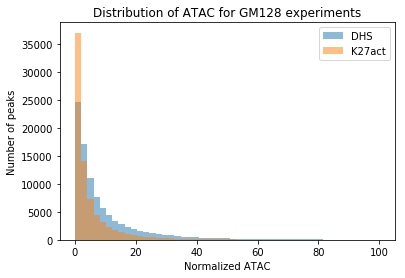

In [72]:
# how should we comine this data?
#bins=np.linspace(0, 50, 50)
bins=50
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['fold_change'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['k27' in n for n in peaks['name']]]['fold_change'], label='K27act', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Log Fold Change K27act over ATAC')
plt.title('Distribution of Fold Change for GM128 experiments')
plt.legend()
plt.show()

bins=np.linspace(0, 100, 50)
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['k27act_norm'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['k27' in n for n in peaks['name']]]['k27act_norm'], label='K27act', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Averge Normalized K27act')
plt.title('Distribution of k27 actetylation for GM128 experiments')
plt.legend()
plt.show()

bins=np.linspace(0, 100, 50)
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['atac_norm'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['k27' in n for n in peaks['name']]]['atac_norm'], label='K27act', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Normalized ATAC')
plt.title('Distribution of ATAC for GM128 experiments')
plt.legend()
plt.show()

In [76]:
# write out
columns='chr start end name fold_change atac_norm k27act_norm'.split()
peaks['score'] = np.log2((peaks['k27act_norm']+1)/(peaks['atac_norm']+1))

peaks.to_csv(annotated_path, columns=columns, index=False, sep='\t')
print(annotated_path)
peaks.head()

merged_annotated.bed


,chr,start,end,name,atac_count,k27act_norm,atac_norm,fold_change,score
0,chr1,566561,567061,Peak_1_ENCFF996CVE_dhs,5.797529e+04,0.699504,64.213301,-5.261980,-5.261980
1,chr1,567327,567827,Peak_2_ENCFF996CVE_dhs,9.448775e+05,0.771372,1046.544312,-9.207929,-9.207929
2,chr1,569673,570173,Peak_3_ENCFF996CVE_dhs,1.515015e+06,1.929082,1678.027423,-9.162962,-9.162962
3,chr1,713665,714165,Peak_19010_ENCFF411MHX_k27,2.001610e+04,29.494085,22.169786,0.396285,0.396285
4,chr1,713872,714372,"Peak_4a_ENCFF996CVE_dhs,Peak_4b_ENCFF996CVE_dh...",2.973488e+04,25.815067,32.934289,-0.339700,-0.339700
